In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Exercises

## Q6: Damped driven pendulum and chaos

There are a large class of ODE integration methods available through the `scipy.integrate.ode()` function.  Not all of them provide _dense output_ -- most will just give you the value at the end of the integration.  

The explicit Runge-Kutta integrator will give you access to the solution at intermediate points and provides methods to interpolate to any value.  You enable this via `dense_output=True`.

The damped driven pendulum obeys the following equations:

$$\dot{\theta} = \omega$$

$$\dot{\omega} = -q \omega - \sin \theta + b \cos \omega_d t$$

here, $\theta$ is the angle of the pendulum from vertical and $\omega$ is the angular velocity.  $q$ is a damping coefficient, $b$ is a forcing amplitude, and $\omega_d$ is a driving frequency.

Choose $q = 0.5$ and $\omega_d = 2/3$.

Integrate the system for different values of $b$ (start with $b = 0.9$ and increase by $0.05$, and plot the results ($\theta$ vs. $t$).  Here's a RHS function to get you started:

In [2]:
q = 0.5
omega_d = 0.66667
b = np.arange(0.9, 2, 0.05)

theta_0 = np.pi/3

In [3]:
def rhs(t, Y, q, omega_d, b):
        """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
        f = np.zeros_like(Y)
        
        f[0] = Y[1]
        f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

        return f

Note that the pendulum can flip over, giving values of $\theta$ outside of $[-\pi, \pi]$.  The following function can be used to restrict it back to $[-\pi, \pi]$ for plotting.

In [4]:
def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

Write a function that takes an initial angle, $\theta_0$, and integrates the system and returns the solution.

Note, the righthand side function, `rhs`, takes additional arguments that you need to pass through the integrator.  The preferred method to do this with the `solve_ivp()` interface appears to be to use `functools.partial()`, as:
```
from functools import partial

r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b), ...)
```

Some values of $b$ will show very non-periodic behavior.  To see chaos, integrate two different pendula that are the same except for $\theta_0$, with only a small difference between then (like 60 degrees and 60.0001 degrees.  You'll see the solutions track for a while, but then diverge.

In [5]:
from scipy import integrate
from functools import partial

In [6]:
def ode_integrate(X0, dt, tmax, bi):
    """ integrate using the VODE method, storing the solution each dt """

    r = integrate.solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=bi), (0.0, tmax), X0,
                            method="RK45", dense_output=True)

    # get the solution at intermediate times
    ts = np.arange(0.0, tmax, dt)
    
    Xs = restrict_theta(r.sol(ts))
    #Xs = r.sol(ts)
    return ts, Xs

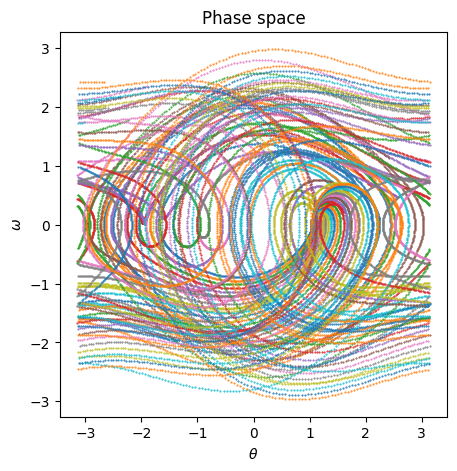

In [7]:
fig, ax = plt.subplots(figsize=(5,5))

for bi in b:
    t, X = ode_integrate(np.array([theta_0, 0.0]), 0.02, 30, bi)
    ax.plot(X[0,:], X[1,:], '.', markersize=1)
    
plt.title("Phase space")
plt.ylabel( r"$\omega$")
plt.xlabel( r"$\theta$")

plt.show()

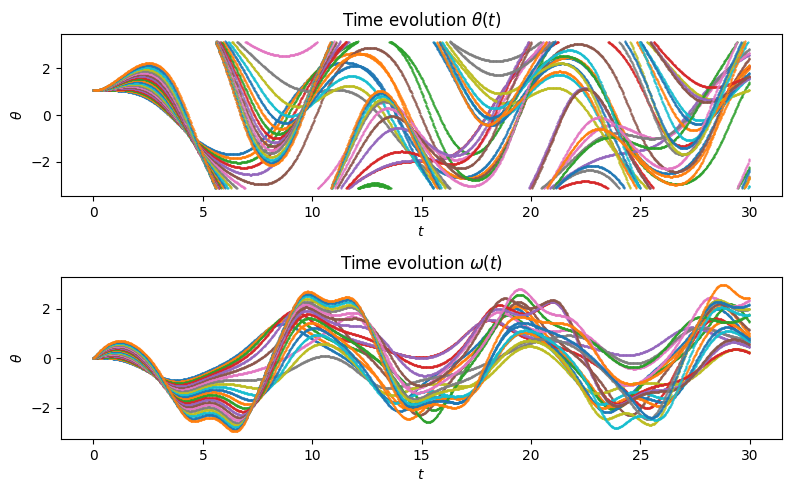

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(8,5))

for bi in b:
    t, X = ode_integrate(np.array([theta_0, 0.0]), 0.02, 30, bi)
    ax[0].plot(t, X[0,:], '.', markersize=1)
    ax[1].plot(t, X[1,:], '.', markersize=1)
    
ax[0].set_title(r"Time evolution $\theta(t)$")
ax[1].set_title(r"Time evolution $\omega(t)$")
ax[0].set_xlabel( r"$t$")
ax[1].set_xlabel( r"$t$")
ax[0].set_ylabel( r"$\theta$")
ax[1].set_ylabel( r"$\theta$")

fig.tight_layout(pad=1)

plt.show()

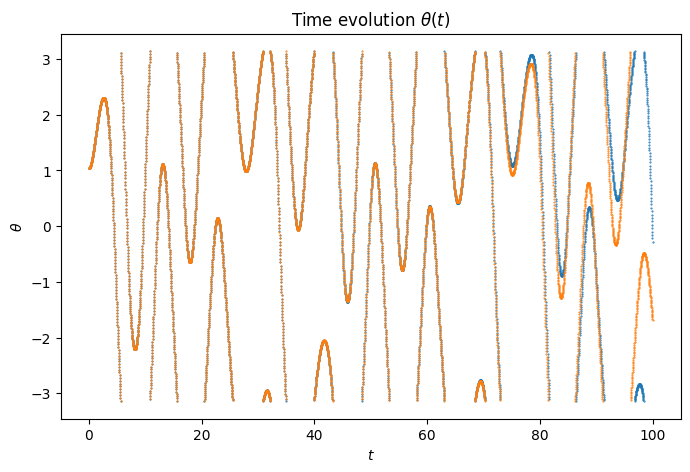

In [9]:
fig, ax = plt.subplots(figsize=(8,5))


theta_0 = np.pi/3
dt = 1e-5

t1, X1 = ode_integrate(np.array([theta_0, 0.0]), 0.02, 100, 2)
ax.plot(t1, X1[0,:], '.', markersize=1)

t2, X2 = ode_integrate(np.array([theta_0+dt, 0.0]), 0.02, 100, 2)
ax.plot(t2, X2[0,:], '.', markersize=1)
    
plt.title(r"Time evolution $\theta(t)$")
plt.xlabel( r"$t$")
plt.ylabel( r"$\theta$")

plt.show()

## Q8: FFT of the chaotic pendulum

In Q6 we looked at ODEs and the chaotic pendulum, and were interested in writing a method to integrate the pendulum in time.

Here we want to examine its behavior in frequency space.  The code below will integrate the chaotic pendulum, while requesting that the solution be stored at points spaced with a fixed dt, which makes it suitable for taking the FFT.

In [10]:
from functools import partial
from scipy.integrate import solve_ivp

def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum and return solution with dt"""

    # points in time where we'll request the solution
    tpoints = np.arange(0.0, tend, dt)
    
    r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b),
                  [0.0, tend], [theta0, 0.0],
                  method='RK45', t_eval=tpoints)

    return r.t, r.y

The call below will give an undamped pendulum.  For a small amplitude, since we have $L = g$ in our pendulum, the period is simply $T = 2\pi$, and the frequency is $\nu_k = 1/(2\pi)$.  We plot things in terms of angular frequency, $\omega_k = 2\pi \nu_k$, so all the power will be at $\omega_k = 1$.

In [11]:
t, y = int_pendulum(np.radians(10), 0.0, 0.6666, 0.0, 200.0, 0.1)

Your task is to complete the power spectrum routine below to calculate the FFT of theta and plot it.  Experiment with the damping and driving parameters to see the complexity of the pendulum in frequency space when it becomes chaotic.  For reference, here's a plot of the solution theta

Text(0, 0.5, '$\\theta$')

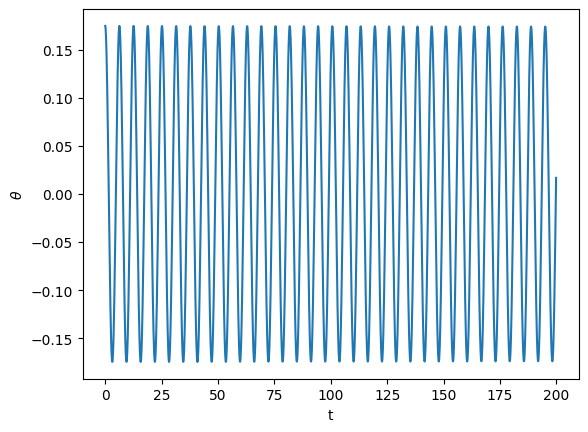

In [12]:
plt.plot(t, restrict_theta(y[0,:]))
plt.xlabel("t")
plt.ylabel(r"$\theta$")

In [13]:
def power_spectrum(t, theta0):
    """ return the power spectrum of theta.  For the frequency
        component, return it in terms of omega """

    theta = restrict_theta(theta0)

    fk = np.fft.rfft(theta)

    npts = len(t)
    norm = 2/npts

    fk = fk*norm
    
    k = np.fft.rfftfreq(npts)

    kfreq = k*npts/(max(t)+t[1])

    return 2*np.pi*kfreq, fk


In [14]:
omegak, fk = power_spectrum(t, y)

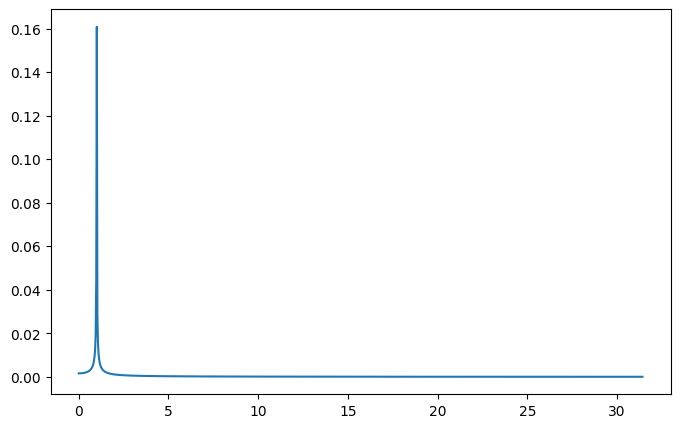

In [15]:
plt.figure(figsize=(8,5))

plt.plot(omegak, np.abs(fk[0]))
plt.show()

#### Varying damping coefficient $q$

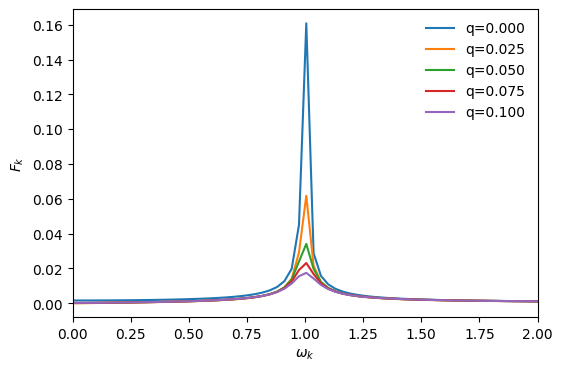

In [16]:
q = np.linspace(0, 0.1, 5)

fig, ax = plt.subplots(figsize=(6,4))

for qi in q:
    t, y = int_pendulum(np.radians(10), qi, 0.6666, 0.0, 200.0, 0.1)
    omegak, fk = power_spectrum(t, y)
    ax.plot(omegak, np.abs(fk[0]), label=f"q={qi:.3f}")
    ax.set_xlim(0,2)

plt.legend(frameon=False)
plt.xlabel(r"$\omega_k$")
plt.ylabel(r"$F_k$")
plt.show()

#### Varying forcing amplitude $b$

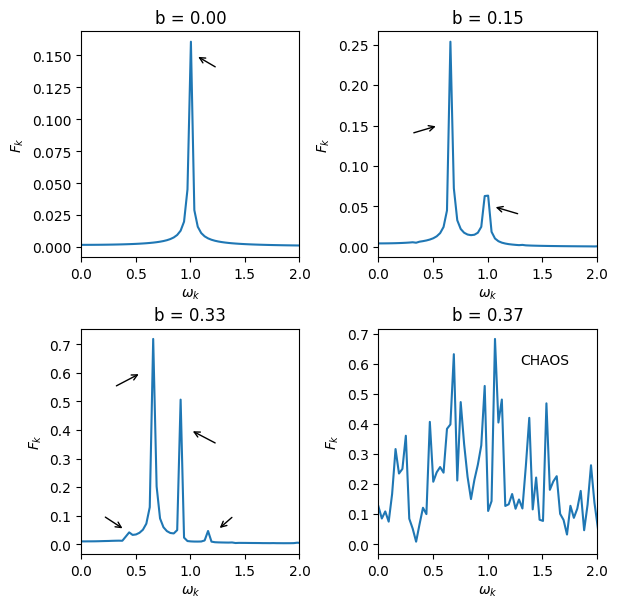

In [17]:
b = np.array([0, 0.15, 0.33, 0.37])

fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax = ax.flatten()

for i in range(4): # not so pythonistic
    t, y = int_pendulum(np.radians(10), 0, 0.6666, b[i], 200.0, 0.1)
    omegak, fk = power_spectrum(t, y)
    ax[i].set_title(f"b = {b[i]:.2f}")
    ax[i].plot(omegak, np.abs(fk[0]))
    ax[i].set_xlim(0,2)
    ax[i].set_xlabel(r"$\omega_k$")
    ax[i].set_ylabel(r"$F_k$")

ax[0].annotate("", xy=(1.05,0.15), xytext=(1.25,0.14), arrowprops=dict(arrowstyle="->"))

ax[1].annotate("", xy=(1.05,0.05), xytext=(1.3,0.04), arrowprops=dict(arrowstyle="->"))
ax[1].annotate("", xy=(0.55,0.15), xytext=(0.3,0.14), arrowprops=dict(arrowstyle="->"))


ax[2].annotate("", xy=(1,0.4), xytext=(1.25,0.35), arrowprops=dict(arrowstyle="->"))
ax[2].annotate("", xy=(1.25,0.05), xytext=(1.4,0.1), arrowprops=dict(arrowstyle="->"))
ax[2].annotate("", xy=(0.55,0.6), xytext=(0.3,0.55), arrowprops=dict(arrowstyle="->"))
ax[2].annotate("", xy=(0.4,0.05), xytext=(0.2,0.1), arrowprops=dict(arrowstyle="->"))

ax[3].annotate("CHAOS", xy=(0,0), xytext=(1.3, 0.6))

plt.tight_layout(pad=0.4)
plt.show()

Chaos emerges after the number of peaks in the power spectrum goes over the Feigenbaum constant $4.67$.
This means we could see a bifurcation in the power spectrum plot with the forcing amplitude as the bifurcation parameter:

In [18]:
bmax = 1
res = 700
tmax = 500
b = np.linspace(0, bmax, res)

omegak = []
fk = []

for bi in b:
    t, y = int_pendulum(np.radians(10), 0, 0.6667, bi, tmax, tmax/res)
    new_omegak, new_fk = power_spectrum(t, y)
    omegak.append(new_omegak)
    fk.append(np.abs(new_fk[0]))

fk = np.array(fk)
omegak = np.array(omegak)

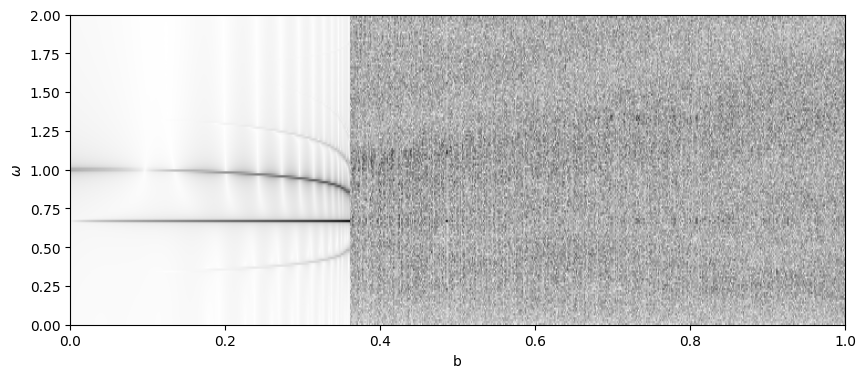

In [19]:
import matplotlib as mpl

plt.figure(figsize=(10,8))

plt.imshow(fk[:, omegak[0] < 2].T, origin='lower', aspect=0.2, extent=[0, bmax, 0, 2], cmap='binary', norm=mpl.colors.PowerNorm(gamma=0.5))
plt.xlabel("b")
plt.ylabel(r"$\omega$")
plt.show()

## Q9: Errors on our fit

We looked at fits, but not what the errors are on the fit.  Look at `scipy.optimize.curve_fit()`.  This is a simplified wrapper on the least squares fitting.  It can return the convariance matrix, the diagonals of which can give the error of the fit for the parameters.  

Make up some data that models a non-linear function (by introducing some random noise) and perform a fit and find the errors on the parameters.

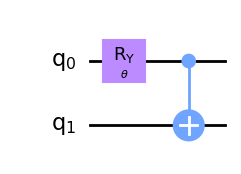

In [20]:
import qiskit as qk

qr = qk.QuantumRegister(2, r"\rm{q}")
qc = qk.QuantumCircuit(qr)

theta = qk.circuit.Parameter(r'$\theta$')

qc.ry(theta, 0)
qc.cx(0,1)

qc.draw('mpl', style='clifford')

Using a quantum circuit on a noisy backend gives us some "original" noisy data for the exercise:

In [21]:
from qiskit import Aer

#simulator
sim_backend = Aer.get_backend('qasm_simulator')

In [22]:
def run_quantum_circuit(t, shots):
    """Quantum circuit made of 2 qubits, a rotation-y gate on the first qubit and a CNOT (control first qubit, target second qubit). 
    It returns the counts dictionary of the measurements. """

    qr = qk.QuantumRegister(2, r"\rm{q}")
    qc = qk.QuantumCircuit(qr)

    theta = qk.circuit.Parameter(r'$\theta$')

    qc.ry(theta, 0)
    qc.cx(0,1)
    qc.measure_all()

    qc = qc.assign_parameters({theta: t})

    job = sim_backend.run(qc, noisy=True, shots=shots)
    counts = job.result().get_counts()

    return counts

def expected_probability(t, *p):
    """ Fit function """
    return p[0]*np.cos(t)+p[1]

def scan_angles(thetas, shots):
    """ Cycles through the angles in the array `thetas`. """
    counts = []

    for t in thetas:
        c = run_quantum_circuit(t, shots)
        try:
            counts.append(c['00']/shots)
        except:
            counts.append(0)

    return np.array(counts)

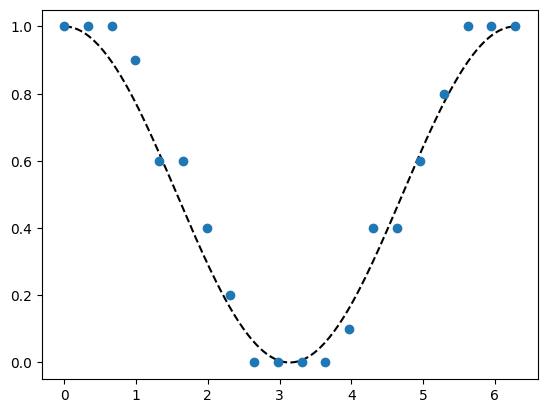

In [23]:
N = 20
shots = 10

thetas = np.linspace(0, 2*np.pi, N)
counts = scan_angles(thetas, shots)

fine_thetas = np.linspace(0, 2*np.pi, 200)

plt.plot(fine_thetas, expected_probability(fine_thetas, 0.5, 0.5), 'k--')
plt.plot(thetas, counts, 'o', color='tab:blue')
plt.show()

In [24]:
from scipy import optimize

pars, cov = optimize.curve_fit(expected_probability, thetas, counts, p0=[0, 0])
pars, cov

(array([0.52987462, 0.52350627]),
 array([[ 4.03953475e-04, -2.01976732e-05],
        [-2.01976732e-05,  2.12075576e-04]]))

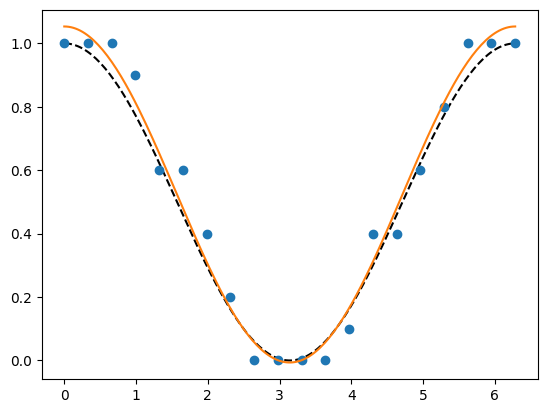

In [25]:
plt.plot(fine_thetas, expected_probability(fine_thetas, 0.5, 0.5), 'k--')
plt.plot(thetas, counts, 'o', color='tab:blue')
plt.plot(fine_thetas, expected_probability(fine_thetas, *pars), color='tab:orange')
plt.show()

<Axes: >

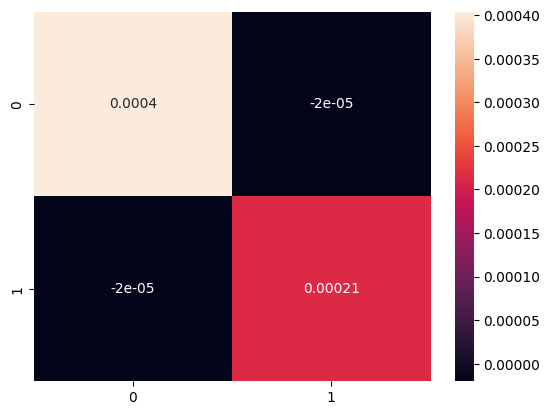

In [26]:
import seaborn as sn

sn.heatmap(cov, annot=True)